In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats
from nba_api.stats.endpoints.leaguedashteamptshot import LeagueDashTeamPtShot

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
reg_base = LeagueDashPlayerStats(per_mode_detailed='PerGame', season_type_all_star='Regular Season', season='2020-21').get_data_frames()[0]
playoff_base = LeagueDashPlayerStats(per_mode_detailed='PerGame', season_type_all_star='Playoffs', season='2020-21').get_data_frames()[0]

In [6]:
merged_df = pd.merge(left=reg_base, right=playoff_base, on=('PLAYER_ID', 'PLAYER_NAME'), suffixes=('_REGULAR', '_PLAYOFF'))

In [10]:
qualified_po = merged_df.loc[merged_df.MIN_PLAYOFF > 15]

In [13]:
qualified_po.loc[:, 'TS_PCT_PLAYOFF'] = qualified_po.PTS_PLAYOFF / (2 * (qualified_po.FGA_PLAYOFF + 0.44 * qualified_po.FTA_PLAYOFF)) * 100
qualified_po.loc[:, 'TS_PCT_REGULAR'] = qualified_po.PTS_REGULAR / (2 * (qualified_po.FGA_REGULAR + 0.44 * qualified_po.FTA_REGULAR)) * 100

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
qualified_po.loc[:, 'TS_DIFF'] = qualified_po.TS_PCT_PLAYOFF - qualified_po.TS_PCT_REGULAR

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:

sort_qual = qualified_po.sort_values(by='TS_DIFF', ascending=False).iloc[:10]

In [31]:
team_root_dir = f'../../team_logos/'
player_root_dir = f'../player_imgs/'

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from pathlib import Path
zoom = 1.0

def get_player_img(player_id):
    #print(path)
    if not Path(f'{player_root_dir}{player_id}.png').exists():
        url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
        response = requests.get(url)
        with open(f'{player_root_dir}{player_id}.png', 'wb') as f:
            f.write(response.content)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

[Text(0.0, 0, ''),
 Text(0.1, 0, ''),
 Text(0.2, 0, ''),
 Text(0.30000000000000004, 0, ''),
 Text(0.4, 0, ''),
 Text(0.5, 0, '')]

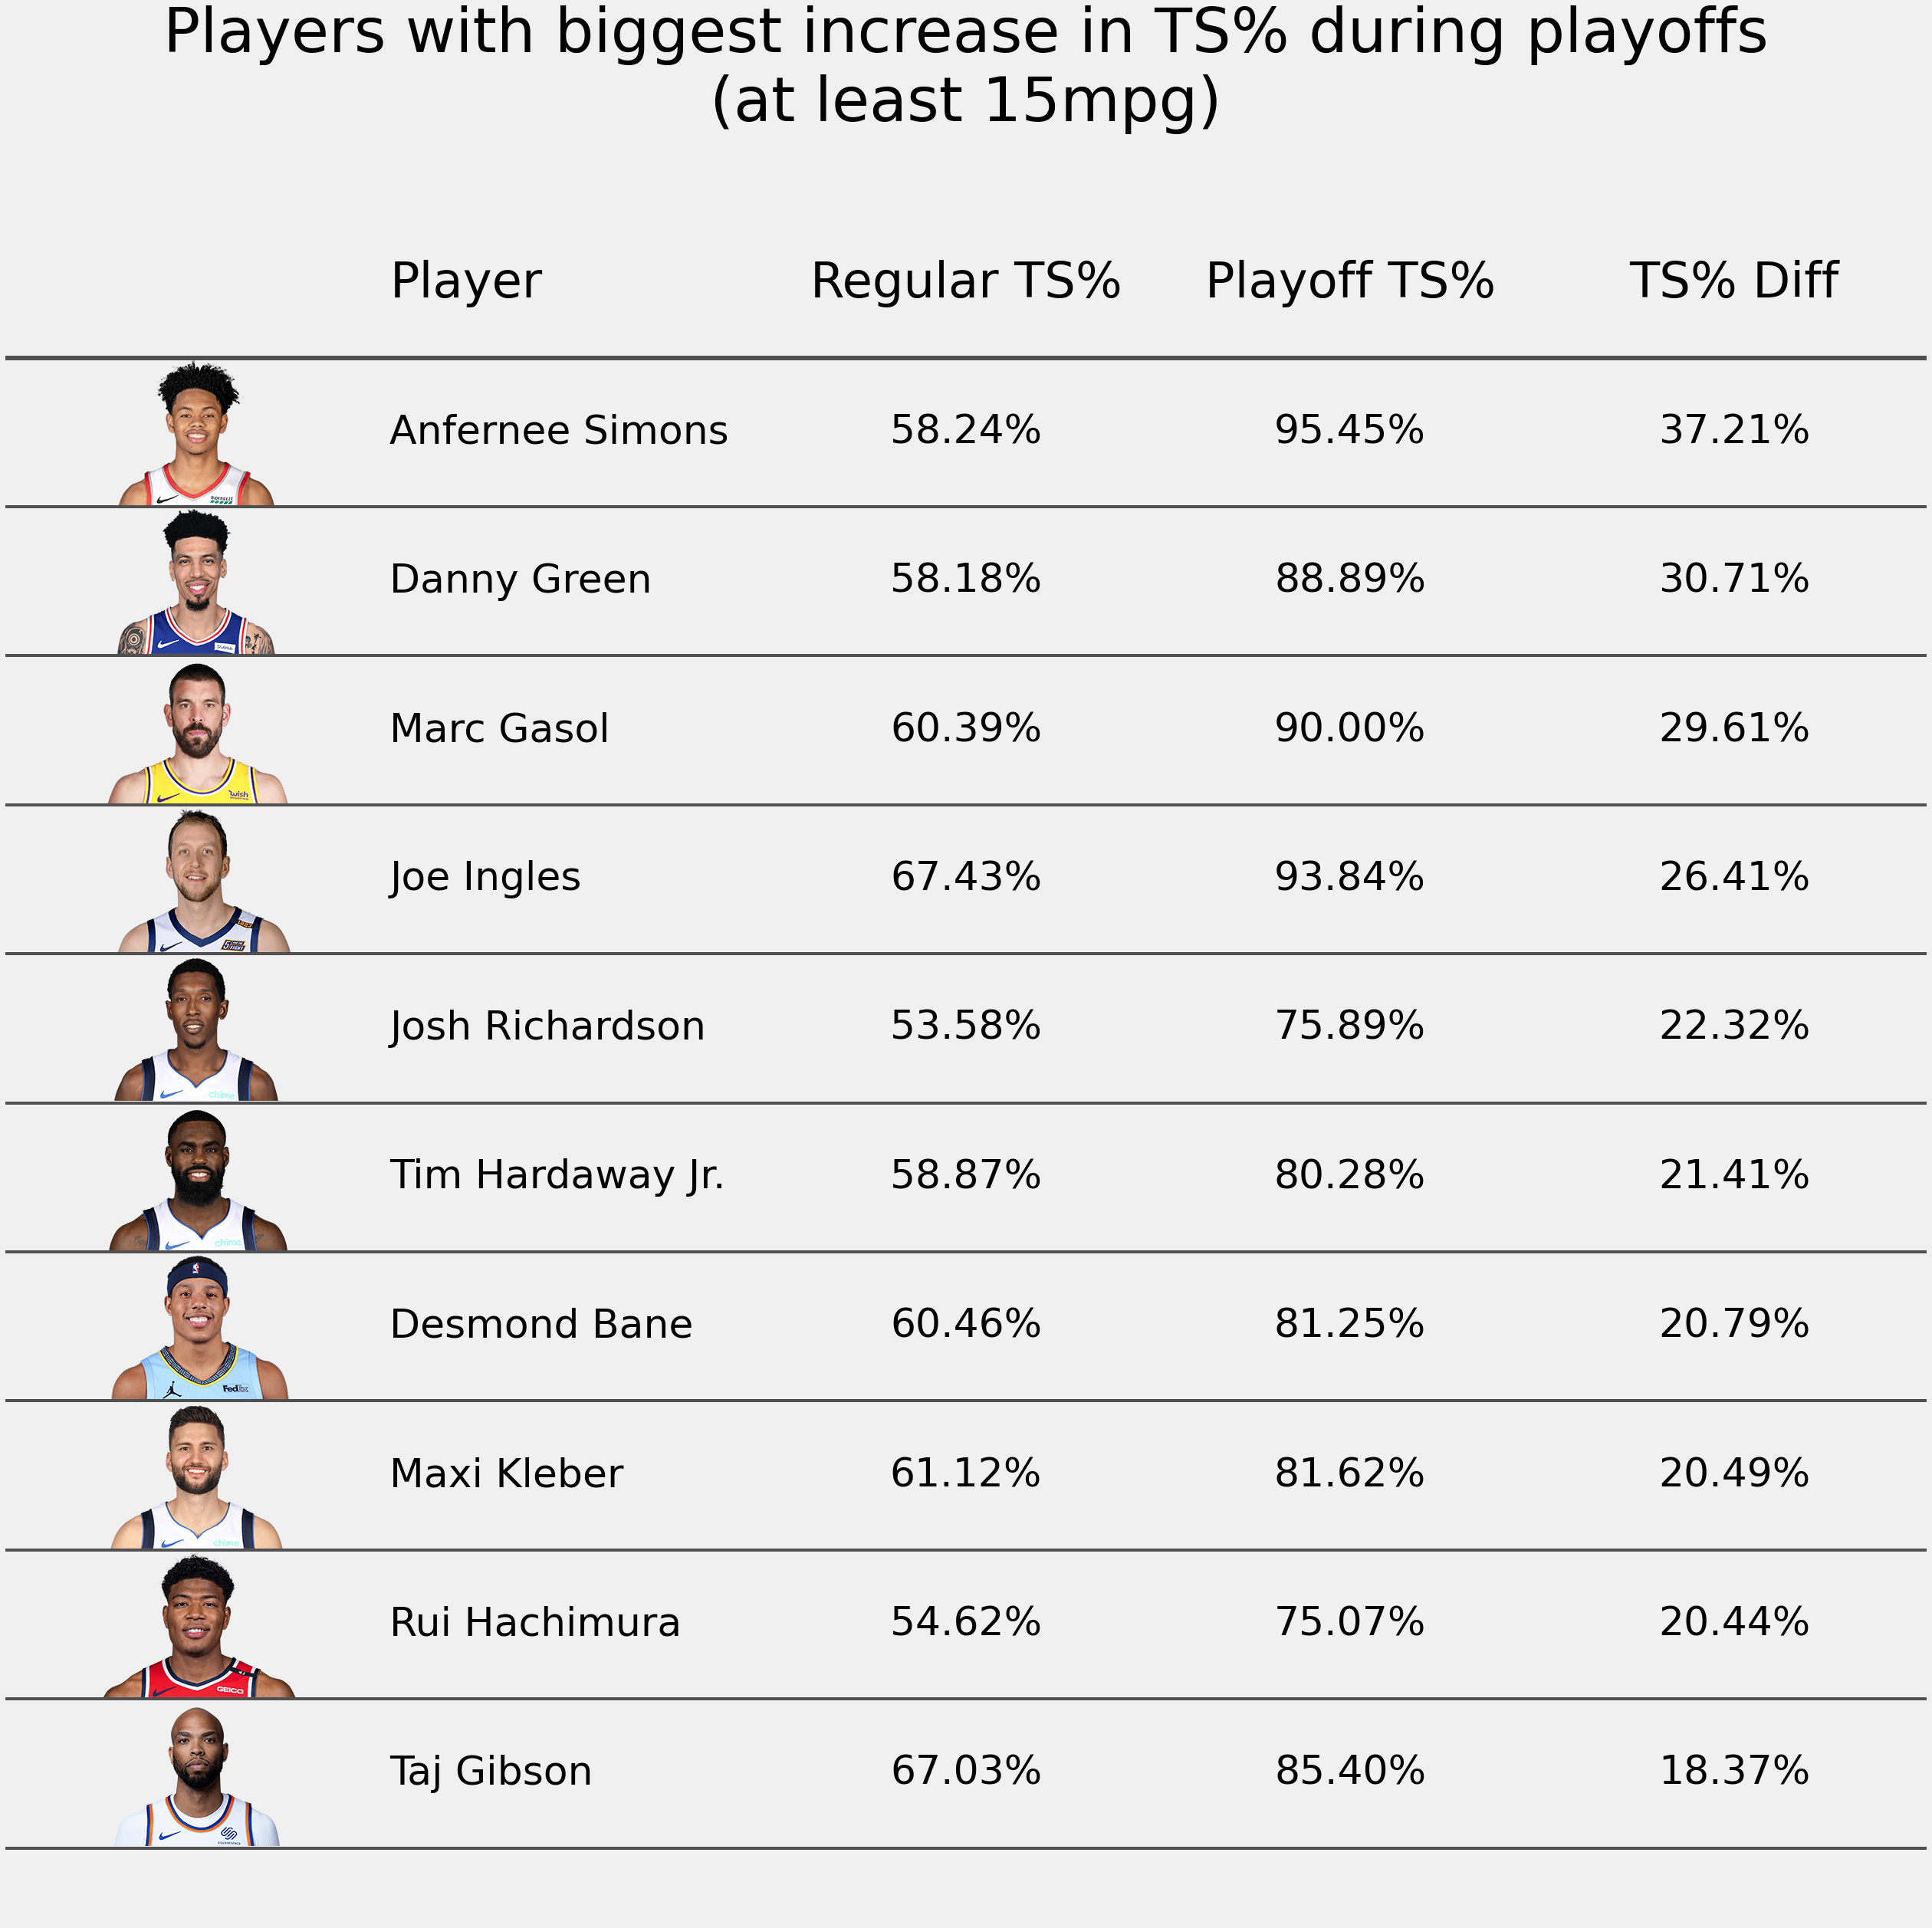

In [33]:
fig, ax = plt.subplots(figsize=(40, 40))
font_size = 52
font_title = 64
title_size = 80
top = len(sort_qual)
#top = 10

for i in range(top):
    item = sort_qual.iloc[i]
    y_coord = top - i - 1
    #if i % 2 == 1:
    #    color = bball_cofee
    #    rect = Rectangle((-0.5, y_coord + 0.5), width=5, height=1, fill=True, color=color)
    #    ax.add_patch(rect)
    ax.text(x=0.1, y=y_coord, ha='left', va='center', s=item.PLAYER_NAME, size=font_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#1A1A1A', alpha=0.75, lw=4)
    
    ax.text(x=0.25, y=y_coord, ha='center', va='center', s=f"{item.TS_PCT_REGULAR:.2f}%", size=font_size)
    ax.text(x=0.35, y=y_coord, ha='center', va='center', s=f"{item.TS_PCT_PLAYOFF:.2f}%", size=font_size)
    ax.text(x=0.45, y=y_coord, ha='center', va='center', s=f"{item.TS_DIFF:.2f}%", size=font_size)
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (0.05, y_coord), frameon=False)
    ax.add_artist(ab)
    
ax.text(x=0.1, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=0.25, y=top, s='Regular TS%', ha='center', va='center', size=font_title)
ax.text(x=0.35, y=top, s='Playoff TS%', ha='center', va='center', size=font_title)
ax.text(x=0.45, y=top, s='TS% Diff', ha='center', va='center', size=font_title)


ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, alpha=0.75, lw=6, color='#1A1A1A')
ax.set_title("Players with biggest increase in TS% during playoffs\n(at least 15mpg)", size=title_size)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=0, right=0.5)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])

In [28]:
sort_bottom = qualified_po.sort_values(by='TS_DIFF').iloc[:10]

In [29]:
sort_bottom

,PLAYER_ID,PLAYER_NAME,TEAM_ID_REGULAR,TEAM_ABBREVIATION_REGULAR,AGE_REGULAR,GP_REGULAR,W_REGULAR,L_REGULAR,W_PCT_REGULAR,MIN_REGULAR,...,PTS_RANK_PLAYOFF,PLUS_MINUS_RANK_PLAYOFF,NBA_FANTASY_PTS_RANK_PLAYOFF,DD2_RANK_PLAYOFF,TD3_RANK_PLAYOFF,CFID_PLAYOFF,CFPARAMS_PLAYOFF,TS_PCT_PLAYOFF,TS_PCT_REGULAR,TS_DIFF
75,1628960,Grayson Allen,1610612763,MEM,25.0,50,26,24,0.520,25.2,...,148,193,156,26,2,5,"1628960,1610612763",23.946360,58.293005,-34.346645
1,1630174,Aaron Nesmith,1610612738,BOS,21.0,46,22,24,0.478,14.5,...,148,131,137,26,2,5,"1630174,1610612738",22.977941,56.436119,-33.458178
38,201568,Danilo Gallinari,1610612737,ATL,32.0,51,29,22,0.569,24.0,...,100,135,88,26,2,5,"201568,1610612737",30.952381,61.596888,-30.644507
43,1629001,De'Anthony Melton,1610612763,MEM,23.0,52,27,25,0.519,20.1,...,136,186,123,26,2,5,"1629001,1610612763",27.173913,56.592040,-29.418127
114,1628398,Kyle Kuzma,1610612747,LAL,25.0,68,40,28,0.588,28.7,...,137,62,116,26,2,5,"1628398,1610612747",26.157261,55.052919,-28.895658
54,1628978,Donte DiVincenzo,1610612749,MIL,24.0,66,44,22,0.667,27.5,...,145,58,97,26,2,5,"1628978,1610612749",25.471698,54.257095,-28.785397
188,2772,Trevor Ariza,1610612748,MIA,35.0,30,17,13,0.567,28.0,...,145,179,98,26,2,5,"2772,1610612748",27.000000,54.272517,-27.272517
123,202694,Marcus Morris Sr.,1610612746,LAC,31.0,57,38,19,0.667,26.3,...,100,195,121,26,2,5,"202694,1610612746",34.648188,61.445341,-26.797154
108,203484,Kentavious Caldwell-Pope,1610612747,LAL,28.0,67,39,28,0.582,28.4,...,126,42,111,26,2,5,"203484,1610612747",32.573290,58.097748,-25.524458
102,203944,Julius Randle,1610612752,NYK,26.0,71,40,31,0.563,37.6,...,41,109,32,4,2,5,"203944,1610612752",36.023055,56.732580,-20.709525


[Text(0.0, 0, ''),
 Text(0.1, 0, ''),
 Text(0.2, 0, ''),
 Text(0.30000000000000004, 0, ''),
 Text(0.4, 0, ''),
 Text(0.5, 0, ''),
 Text(0.6000000000000001, 0, '')]

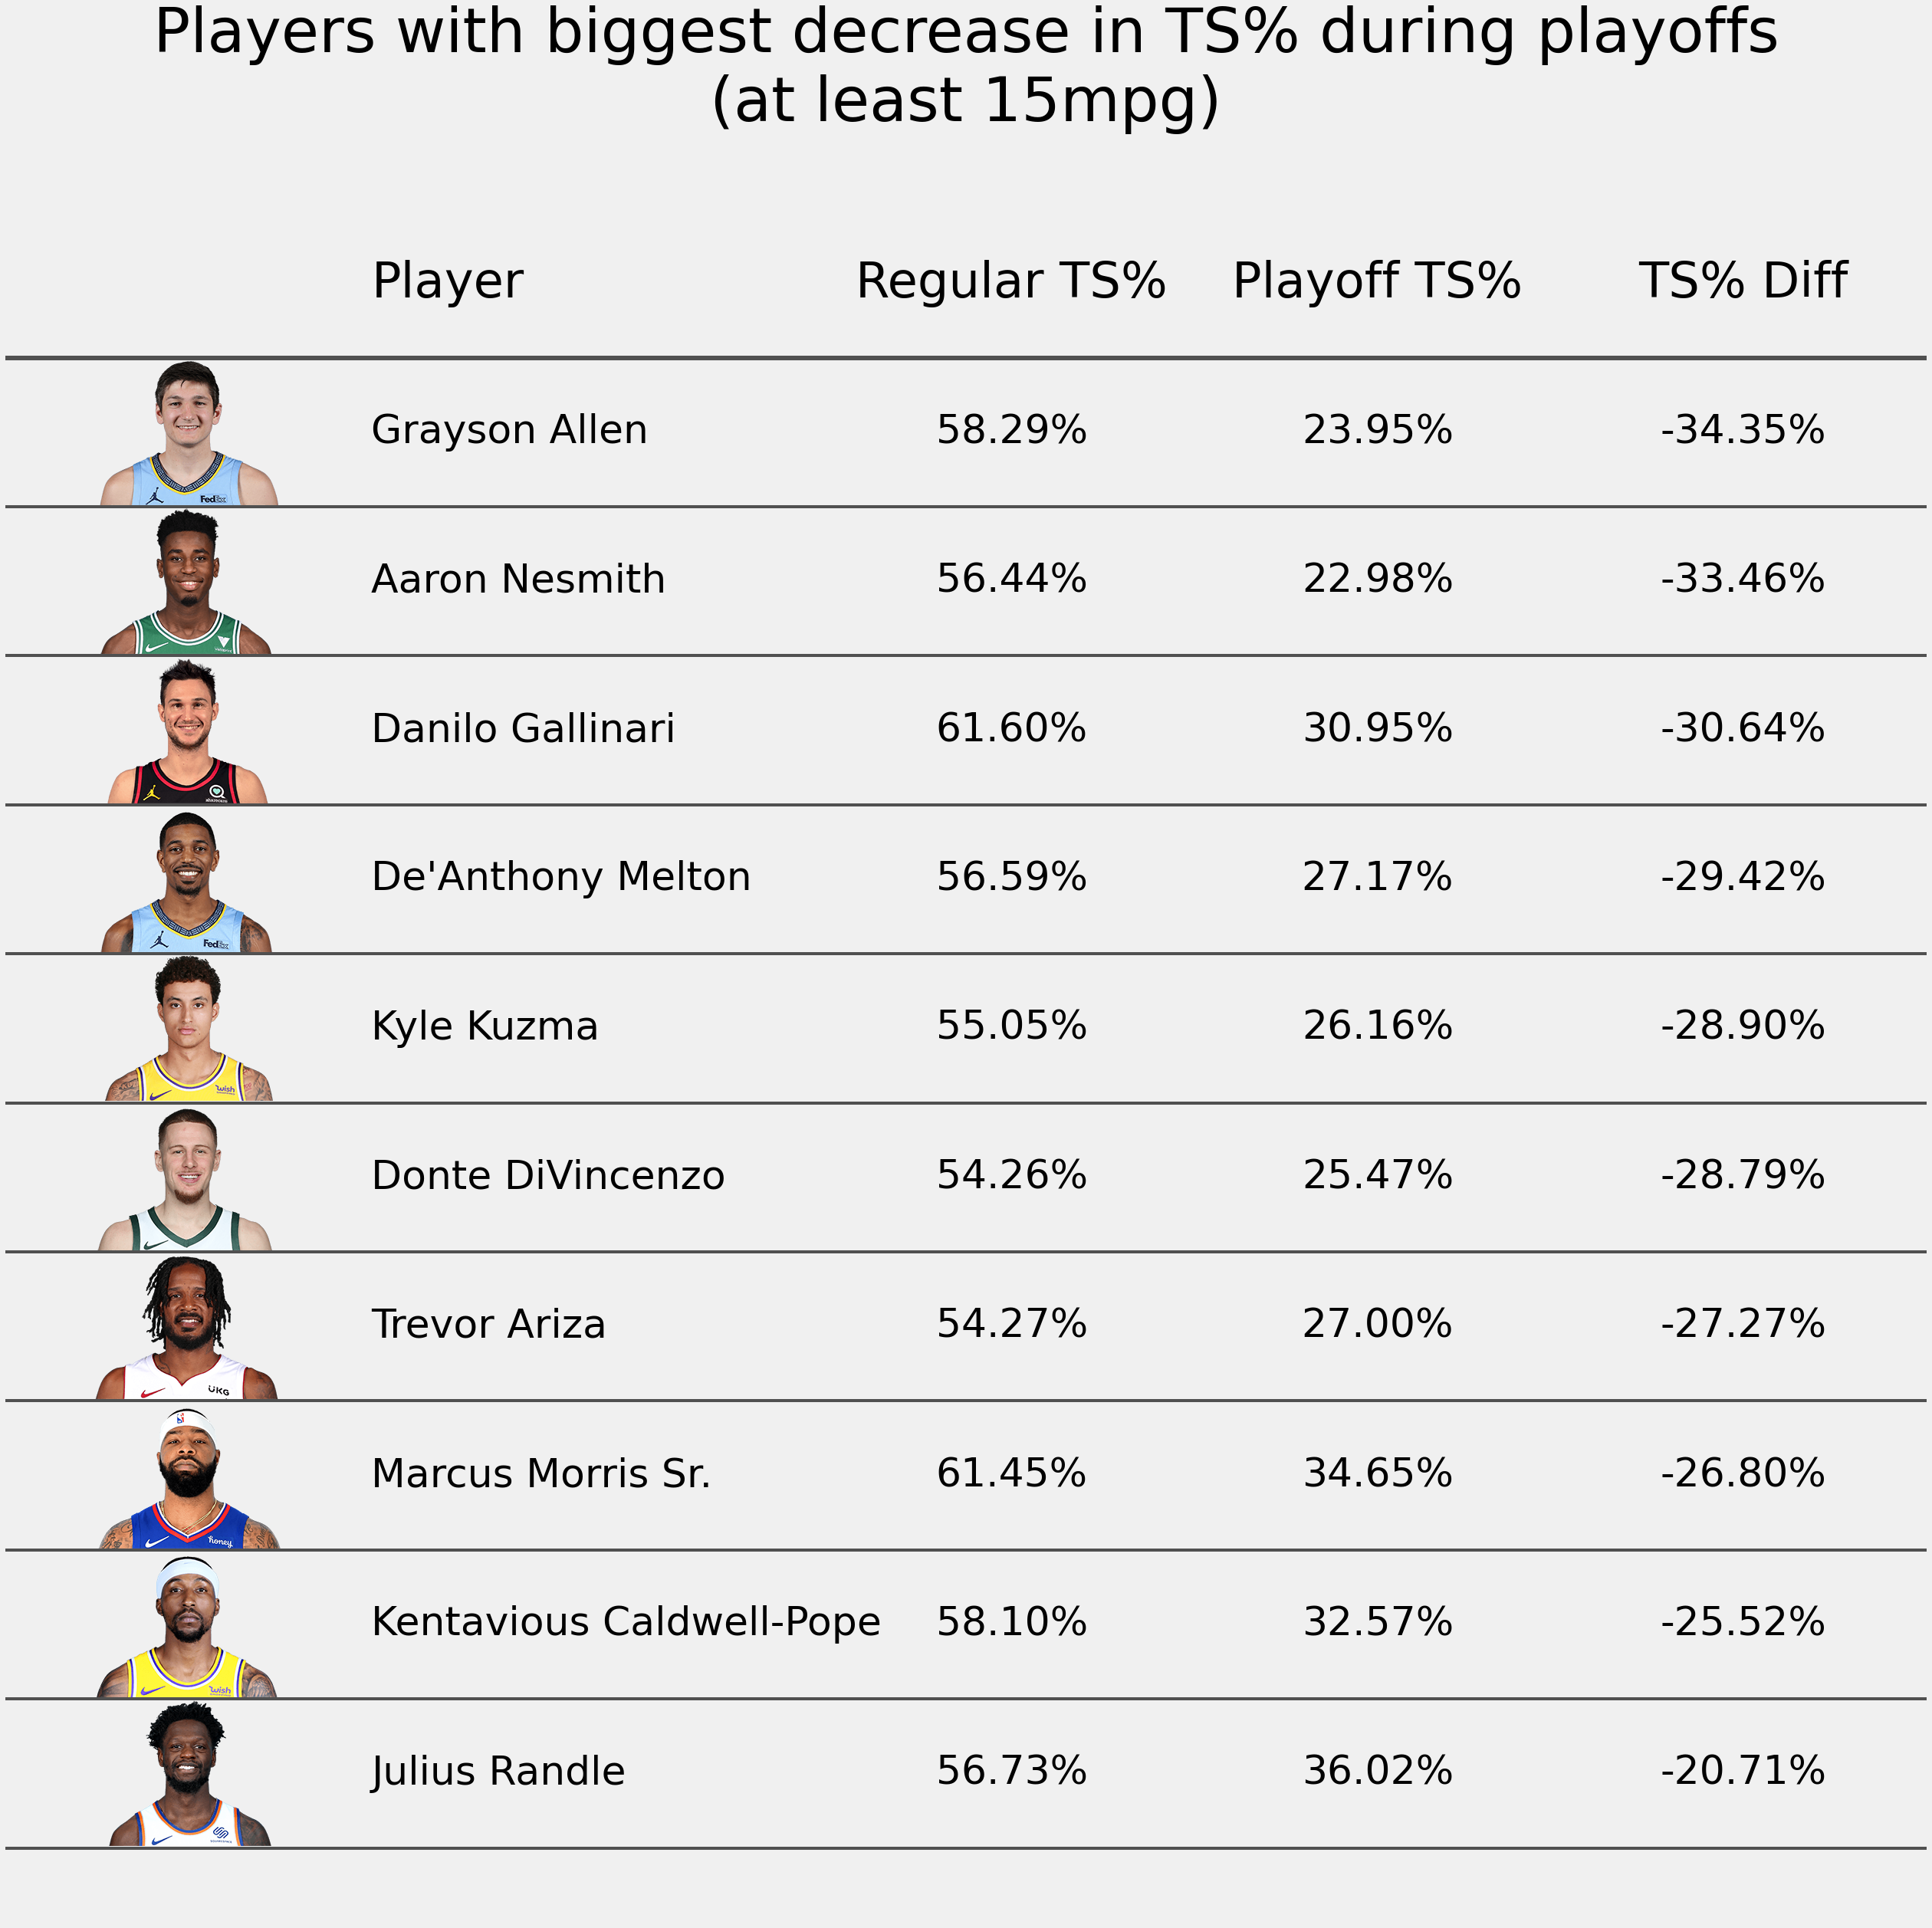

In [35]:
fig, ax = plt.subplots(figsize=(40, 40))
font_size = 52
font_title = 64
title_size = 80
top = len(sort_bottom)
#top = 10

for i in range(top):
    item = sort_bottom.iloc[i]
    y_coord = top - i - 1
    #if i % 2 == 1:
    #    color = bball_cofee
    #    rect = Rectangle((-0.5, y_coord + 0.5), width=5, height=1, fill=True, color=color)
    #    ax.add_patch(rect)
    ax.text(x=0.1, y=y_coord, ha='left', va='center', s=item.PLAYER_NAME, size=font_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#1A1A1A', alpha=0.75, lw=4)
    
    ax.text(x=0.275, y=y_coord, ha='center', va='center', s=f"{item.TS_PCT_REGULAR:.2f}%", size=font_size)
    ax.text(x=0.375, y=y_coord, ha='center', va='center', s=f"{item.TS_PCT_PLAYOFF:.2f}%", size=font_size)
    ax.text(x=0.475, y=y_coord, ha='center', va='center', s=f"{item.TS_DIFF:.2f}%", size=font_size)
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (0.05, y_coord), frameon=False)
    ax.add_artist(ab)
    
ax.text(x=0.1, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=0.275, y=top, s='Regular TS%', ha='center', va='center', size=font_title)
ax.text(x=0.375, y=top, s='Playoff TS%', ha='center', va='center', size=font_title)
ax.text(x=0.475, y=top, s='TS% Diff', ha='center', va='center', size=font_title)


ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, alpha=0.75, lw=6, color='#1A1A1A')
ax.set_title("Players with biggest decrease in TS% during playoffs\n(at least 15mpg)", size=title_size)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=0, right=0.525)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])